In [0]:
import pandas as pd
import numpy as np
import re
import os

In [0]:
URL_web = 'https://github.com/alik604/eminem_lyrics_generator/raw/master/data/preprocessed_data_eminem.csv'
URL_local = './data/preprocessed_data_eminem.csv'
lines = pd.read_csv(URL_web,index_col=0)

In [0]:
def clean_text(sentence):
  sentence = sentence.lower()
  sentence = re.sub(r'\[.*?\]', "", sentence) # https://www.regextester.com/97589 &  https://stackoverflow.com/a/40621332
  sentence = re.sub(r"\u2005", "", sentence)

  sentence = re.sub(r"’", "\'", sentence) 
  sentence = re.sub(r"‘", "\'", sentence)
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "what is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"there's", "there is", sentence)
  sentence = re.sub(r"who's", "who is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "cannot", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"\'bout", "about", sentence)
  sentence = re.sub(r"'til", "until", sentence)
  sentence = re.sub(r"c'mon", "come on", sentence)
  sentence = re.sub("\n", " ", sentence)

  sentence = re.sub(r"\u2005", "", sentence)
  sentence = re.sub("[-*/()\"’‘'#/@;:<>{}`+=~|.!?,]", "", sentence) # should it be:  \'   rather than '   
  sentence = re.sub(r"'", "", sentence)
  sentence = re.sub(r"\t", "", sentence)
  sentence = re.sub(r"  ", " ", sentence)
  sentence = re.sub(r"  ", " ", sentence)
  return sentence

lines.lines = lines.lines.apply(lambda line: clean_text(line))

In [5]:
lines.head()

,lines
0,look i was gonna go easy on you not to hurt y...
1,you sound like a bitch bitch shut the fuck up...
2,look if you had one shot or one opportunity t...
3,i am friends with the monster that is under m...
4,ugh you are a monster i can swallow a bottle ...


In [6]:
lines.shape

(84, 1)

In [0]:
lines.lines = lines.lines.apply(lambda line: line.split())

In [0]:
x_train = [line[:-1] for line in lines.lines]
y_train = [line[1:] for line in lines.lines]

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
tokenizer = Tokenizer()

In [0]:
tokenizer.fit_on_texts(lines.lines)

In [0]:
x_train = tokenizer.texts_to_sequences(x_train)
y_train = tokenizer.texts_to_sequences(y_train)

In [0]:
word2idx = tokenizer.word_index
idx2word = {value: key for key, value in word2idx.items()}

In [0]:
word2idx["<pad>"] = 0
idx2word[0] = "<pad>"

In [15]:
lengths = []

for sequence in x_train:
    lengths.append(len(sequence))
    
lengths = pd.Series(lengths)
lengths.describe()

count      84.000000
mean      968.416667
std       266.926559
min       114.000000
25%       800.500000
50%       919.000000
75%      1076.750000
max      1784.000000
dtype: float64

In [16]:
maxlen = 1024
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
vocab_size

8526

In [0]:
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
y_train = pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')

In [0]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Input, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))
model.add(GRU(units=1024, return_sequences=True))
model.add(Dense(vocab_size))

In [0]:
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True))

In [21]:
history = model.fit(x_train, y_train, epochs=50, verbose=1) #400

Epoch 1/50
3/3 [==============================] - 1s 301ms/step - loss: 7.8615
Epoch 2/50
3/3 [==============================] - 1s 293ms/step - loss: 7.7088
Epoch 3/50
3/3 [==============================] - 1s 292ms/step - loss: 5.8166
Epoch 4/50
3/3 [==============================] - 1s 294ms/step - loss: 5.7300
Epoch 5/50
3/3 [==============================] - 1s 293ms/step - loss: 5.6921
Epoch 6/50
3/3 [==============================] - 1s 290ms/step - loss: 5.6479
Epoch 7/50
3/3 [==============================] - 1s 293ms/step - loss: 5.6089
Epoch 8/50
3/3 [==============================] - 1s 294ms/step - loss: 5.6140
Epoch 9/50
3/3 [==============================] - 1s 290ms/step - loss: 5.5925
Epoch 10/50
3/3 [==============================] - 1s 293ms/step - loss: 5.5906
Epoch 11/50
3/3 [==============================] - 1s 292ms/step - loss: 5.5847
Epoch 12/50
3/3 [==============================] - 1s 291ms/step - loss: 5.5742
Epoch 13/50
3/3 [==============================] 

In [0]:
# model.save("model.h5")
# model = load_model("model.h5")

In [0]:
def generate(word):
    word = clean_text(word)
    inputs = np.zeros((1, 1))
    inputs[0, 0] = word2idx[word]
    count = 1
    while count <= 100:
        pred = model.predict(inputs)
        word = np.argmax(pred)
        if word >= vocab_size:
            word = vocab_size - 1

        inputs[0, 0] = word
        
        print(idx2word[word], end=" ")
        count += 1


In [30]:
print('slim: ', generate("slim"))
print('kill: ', generate("kill"))

it is not am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am slim:  None
least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least am hitting least 

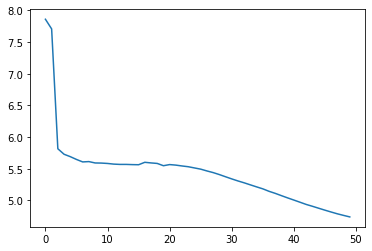

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(50), history.history['loss'])

In [31]:
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(x_train, y_train, epochs=5, verbose=1)

Epoch 1/5
3/3 [==============================] - 1s 292ms/step - loss: 4.9049
Epoch 2/5
3/3 [==============================] - 1s 291ms/step - loss: 4.7854
Epoch 3/5
3/3 [==============================] - 1s 293ms/step - loss: 4.7432
Epoch 4/5
3/3 [==============================] - 1s 294ms/step - loss: 4.7215
Epoch 5/5
3/3 [==============================] - 1s 292ms/step - loss: 4.6773


In [32]:
print('slim: ', generate("slim"))
print('kill: ', generate("kill"))

you am hitting syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing slim:  None
least know you am hitting syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syncing syn